In [ ]:
import pandas as pd
import numpy as np

In [ ]:
wind07 = pd.read_csv('/content/drive/My Drive/Shell_Windfarm_Optimization/Shell_Hackathon Dataset/Wind Data/wind_data_2007.csv')

In [ ]:
wind07.head()

,date,drct,sped
0,2007-01-01 00:20,290.0,12.829798
1,2007-01-01 00:50,290.0,15.842659
2,2007-01-01 01:20,290.0,15.270610
3,2007-01-01 01:50,300.0,13.332094
4,2007-01-01 02:20,290.0,12.639211


In [ ]:
wind07.shape

(15548, 3)

In [ ]:
wind07.describe()

,drct,sped
count,15548.000000,15548.000000
mean,203.832004,8.961912
std,93.268753,4.612641
min,10.000000,0.680265
25%,150.000000,5.415578
50%,210.000000,8.532853
75%,270.000000,11.820551
max,360.000000,29.879753


In [ ]:
wind07.isnull().sum()

date    0
drct    0
sped    0
dtype: int64

In [ ]:
wind07.dtypes

date     object
drct    float64
sped    float64
dtype: object

In [ ]:
power_curve = pd.read_csv('/content/drive/My Drive/Shell_Windfarm_Optimization/Shell_Hackathon Dataset/power_curve.csv')

In [ ]:
power_curve.head()

,Wind Speed (m/s),Thrust Coeffecient,Power (MW)
0,0.0,0.0,0.0
1,0.1,0.0,0.0
2,0.2,0.0,0.0
3,0.3,0.0,0.0
4,0.4,0.0,0.0


In [ ]:
power_curve.shape

(501, 3)

In [ ]:
power_curve.describe()

,Wind Speed (m/s),Thrust Coeffecient,Power (MW)
count,501.000000,501.000000,501.000000
mean,25.000000,0.187915,0.939948
std,14.477051,0.296416,1.295598
min,0.000000,0.000000,0.000000
25%,12.500000,0.000000,0.000000
50%,25.000000,0.000000,0.000000
75%,37.500000,0.240069,2.681933
max,50.000000,0.882555,3.000000


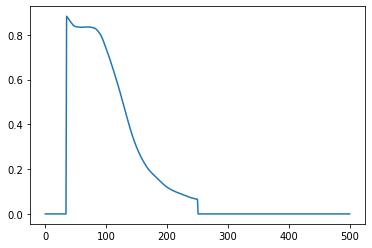

In [ ]:
power_curve['Thrust Coeffecient'].plot()

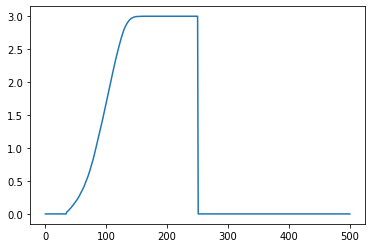

In [ ]:
power_curve['Power (MW)'].plot()

In [ ]:
test_loc = pd.read_csv('/content/drive/My Drive/Shell_Windfarm_Optimization/Shell_Hackathon Dataset/turbine_loc_test.csv')

In [ ]:
test_loc.head()

,x,y
0,3690.323986,370.757560
1,3259.406706,2682.588354
2,478.523823,326.121719
3,2028.458028,1131.161344
4,165.682335,1288.756179


In [ ]:
test_loc.shape

(50, 2)

In [ ]:
test_loc.describe()

,x,y
count,50.000000,50.000000
mean,2082.113991,1909.937418
std,1106.587805,1102.779365
min,165.682335,108.376532
25%,1108.030408,978.319584
50%,2098.434607,1914.736951
75%,2969.732940,2761.302889
max,3930.650522,3936.067231


In [ ]:
import sys
sys.path.append('/content/drive/My Drive/Shell_Windfarm_Optimization/Farm_Evaluator_Vec.py')

In [ ]:
import glob
filenames = glob.glob('/content/drive/My Drive/Shell_Windfarm_Optimization/Shell_Hackathon Dataset/Wind Data/wind_data*.csv')

In [ ]:
wind = pd.concat([pd.read_csv(f) for f in filenames],ignore_index=True)
wind.to_csv('/content/drive/My Drive/Shell_Windfarm_Optimization/Shell_Hackathon Dataset/Wind Data/wind.csv',index=False)

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on: xxxx
@author   : Anon

NAME
    Farm_Evalautor.py
    
PYTHON VERSION   
    3.7.3 
    
DESCRIPTION
    Calculates Annual Energy Production (AEP) of a Wind Farm
    ============================================================    
    
    This is vectorzied version of Farm_Evalautor.py. 
    Farm_Evalautor_Vec.py is a python file that calculates AEP (GWh)
    of a certain arrangement of wind turbines in a farm, under 
    given annual wind conditions. 
    
    The code in this script for wake-effect modeling is based on
    standard Jensen (PARK) model. 
    I. Katic, J. Hojstrup and N. Jensen, "A simple model for cluster 
    efficiency," in European Wind Energy Association Conference and 
    Exhibition, 1986.
    
    As its inputs, the code takes three data files containing info 
    about:
    - Turbine Locations
    - Turbine Power Curve
    - Annual Wind Conditions
    
PACKAGE LIST
    You may need to install the package Shapely in your
    python distribution. These are not pre-installed. 
    =============================================================
    Packages Used:
    Numpy
    Pandas
    Shapely
    math (built-in)
    
OPTIMIZATION USAGE
    This vectorized version is faster than unvectorized version
    Farm_Evalautor.py. Due to speed benefits, we advise you to use 
    the function getAEP in this script while developing the optimizer. 
    =============================================================
    
    One way to use getAEP function as AEP evaluator while optimizing is:
    - STEPz Import the relevant function from Farm_Evalautor_Vec. 
              from Farm_Evalautor_Vec import getTurbLoc, loadPowerCurve, 
              binWindResourceData, preProcessing, getAEP
    - STEP 2. Set Turbine Radius to 50.0. First arg of getAEP
    - STEP 3. Load Turbine Locations. Using function getTurbLoc
    - STEP 4. Load Power Curve. Using function loadPowerCurve
    - STEP 5. Load wind instance probabilities. 
              Using function binWindResourceData
    - STEP 6. Perform Preprocessing by calling function preProcessing.
              We do preprocessing to avoid same repeating calculations.
              Do them once. 
    - STEP 7. Finally, call function getAEP
    
    This makes it easy to control the reloading of data and hence achieve
    better performance.      
"""

# Module List
import numpy  as np
import pandas as pd                     
from   math   import radians as DegToRad       # Degrees to radians Conversion

from shapely.geometry import Point             # Imported for constraint checking
from shapely.geometry.polygon import Polygon

import warnings
warnings.filterwarnings("ignore")

def getTurbLoc(turb_loc_file_name):
    """ 
    -**-THIS FUNCTION SHOULD NOT BE MODIFIED-**-
    
    Returns x,y turbine coordinates
    
    :Called from
        main function
    
    :param
        turb_loc_file_name - Turbine Loc csv file location
        
    :return
        2D array
    """
    
    df = pd.read_csv(turb_loc_file_name, sep=',', dtype = np.float32)
    turb_coords = df.to_numpy(dtype = np.float32)
    return(turb_coords)


def loadPowerCurve(power_curve_file_name):
    """
    -**-THIS FUNCTION SHOULD NOT BE MODIFIED-**-
    
    Returns a 2D numpy array with information about
    turbine thrust coeffecient and power curve of the 
    turbine for given wind speed
    
    :called_from
        main function
    
    :param
        power_curve_file_name - power curve csv file location
        
    :return
        Returns a 2D numpy array with cols Wind Speed (m/s), 
        Thrust Coeffecient (non dimensional), Power (MW)
    """
    powerCurve = pd.read_csv(power_curve_file_name, sep=',', dtype = np.float32)
    powerCurve = powerCurve.to_numpy(dtype = np.float32)
    return(powerCurve)
    

def binWindResourceData(wind_data_file_name):
    r"""
    -**-THIS FUNCTION SHOULD NOT BE MODIFIED-**-
    
    Loads the wind data. Returns a 2D array with shape (36,15). 
    Each cell in  array is a wind direction and speed 'instance'. 
    Values in a cell correspond to probability of instance
    occurence.  
    
    :Called from
        main function
        
    :param
        wind_data_file_name - Wind Resource csv file  
        
    :return
        1-D flattened array of the 2-D array shown below. Values 
        inside cells, rough probabilities of wind instance occurence. 
        Along: Row-direction (drct), Column-Speed (s). Array flattened
        for vectorization purpose. 
        
                      |0<=s<2|2<=s<4| ...  |26<=s<28|28<=s<30|
        |_____________|______|______|______|________|________|
        | drct = 360  |  --  |  --  |  --  |   --   |   --   |
        | drct = 10   |  --  |  --  |  --  |   --   |   --   |
        | drct = 20   |  --  |  --  |  --  |   --   |   --   |
        |   ....      |  --  |  --  |  --  |   --   |   --   |
        | drct = 340  |  --  |  --  |  --  |   --   |   --   |
        | drct = 350  |  --  |  --  |  --  |   --   |   --   |        
    """
    
    # Load wind data. Then, extracts the 'drct', 'sped' columns
    df = pd.read_csv(wind_data_file_name)
    wind_resource = df[['drct', 'sped']].to_numpy(dtype = np.float32)
    
    # direction 'slices' in degrees
    slices_drct   = np.roll(np.arange(10, 361, 10, dtype=np.float32), 1)
    ## slices_drct   = [360, 10.0, 20.0.......340, 350]
    n_slices_drct = slices_drct.shape[0]
    
    # speed 'slices'
    slices_sped   = [0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 
                        18.0, 20.0, 22.0, 24.0, 26.0, 28.0, 30.0]
    n_slices_sped = len(slices_sped)-1

    
    # placeholder for binned wind
    binned_wind = np.zeros((n_slices_drct, n_slices_sped), 
                           dtype = np.float32)
    
    # 'trap' data points inside the bins. 
    for i in range(n_slices_drct):
        for j in range(n_slices_sped):     
            
            # because we already have drct in the multiples of 10
            foo = wind_resource[(wind_resource[:,0] == slices_drct[i])] 

            foo = foo[(foo[:,1] >= slices_sped[j]) 
                          & (foo[:,1] <  slices_sped[j+1])]
            
            binned_wind[i,j] = foo.shape[0]  
    
    wind_inst_freq   = binned_wind/np.sum(binned_wind)
    wind_inst_freq   = wind_inst_freq.ravel()
    
    return(wind_inst_freq)


def searchSorted(lookup, sample_array):
    """
    -**-THIS FUNCTION SHOULD NOT BE MODIFIED-**-
    
    Returns lookup indices for closest values w.r.t sample_array elements
    
    :called_from
        preProcessing, getAEP
    
    :param
        lookup       - The lookup array
        sample_array - Array, whose elements need to be matched
                       against lookup elements. 
        
    :return
        lookup indices for closest values w.r.t sample_array elements 
    """
    lookup_middles = lookup[1:] - np.diff(lookup.astype('f'))/2
    idx1 = np.searchsorted(lookup_middles, sample_array)
    indices = np.arange(lookup.shape[0])[idx1]
    return indices

   

def preProcessing(power_curve):
    """
    -**-THIS FUNCTION SHOULD NOT BE MODIFIED-**-
    
    Doing preprocessing to avoid the same repeating calculations.
    Record the required data for calculations. Do that once.
    Data are set up (shaped) to assist vectorization. Used later in
    function totalAEP. 
    
    :called_from
        main function
    
    :param
        power_curve - 2D numpy array with cols Wind Speed (m/s), 
                      Thrust Coeffecient (non dimensional), Power (MW)
        
    :return
        n_wind_instances  - number of wind instances (int)
        cos_dir           - For coordinate transformation 
                            2D Array. Shape (n_wind_instances,1)
        sin_dir           - For coordinate transformation 
                            2D Array. Shape (n_wind_instances,1)
        wind_sped_stacked - column staked all speed instances n_turb times. 
        C_t               - 3D array with shape (n_wind_instances, n_turbs, n_turbs)
                            Value changing only along axis=0. C_t, thrust coeff.
                            values for all speed instances. 
    """
    # number of turbines
    n_turbs       =   50
    
    # direction 'slices' in degrees
    slices_drct   = np.roll(np.arange(10, 361, 10, dtype=np.float32), 1)
    ## slices_drct   = [360, 10.0, 20.0.......340, 350]
    n_slices_drct = slices_drct.shape[0]
    
    # speed 'slices'
    slices_sped   = [0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 
                        18.0, 20.0, 22.0, 24.0, 26.0, 28.0, 30.0]
    n_slices_sped = len(slices_sped)-1
    
    # number of wind instances
    n_wind_instances = (n_slices_drct)*(n_slices_sped)
    
    # Create wind instances. There are two columns in the wind instance array
    # First Column - Wind Speed. Second Column - Wind Direction
    # Shape of wind_instances (n_wind_instances,2). 
    # Values [1.,360.],[3.,360.],[5.,360.]...[25.,350.],[27.,350.],29.,350.]
    wind_instances = np.zeros((n_wind_instances,2), dtype=np.float32)
    counter = 0
    for i in range(n_slices_drct):
        for j in range(n_slices_sped): 
            
            wind_drct =  slices_drct[i]
            wind_sped = (slices_sped[j] + slices_sped[j+1])/2
            
            wind_instances[counter,0] = wind_sped
            wind_instances[counter,1] = wind_drct
            counter += 1

	# So that the wind flow direction aligns with the +ve x-axis.			
    # Convert inflow wind direction from degrees to radians
    wind_drcts =  np.radians(wind_instances[:,1] - 90)
    # For coordinate transformation 
    cos_dir = np.cos(wind_drcts).reshape(n_wind_instances,1)
    sin_dir = np.sin(wind_drcts).reshape(n_wind_instances,1)
    
    # create copies of n_wind_instances wind speeds from wind_instances
    wind_sped_stacked = np.column_stack([wind_instances[:,0]]*n_turbs)
   
    # Pre-prepare matrix with stored thrust coeffecient C_t values for 
    # n_wind_instances shape (n_wind_instances, n_turbs, n_turbs). 
    # Value changing only along axis=0. C_t, thrust coeff. values for all 
    # speed instances.
    # we use power_curve data as look up to estimate the thrust coeff.
    # of the turbine for the corresponding closest matching wind speed
    indices = searchSorted(power_curve[:,0], wind_instances[:,0])
    C_t     = power_curve[indices,1]
    # stacking and reshaping to assist vectorization
    C_t     = np.column_stack([C_t]*(n_turbs*n_turbs))
    C_t     = C_t.reshape(n_wind_instances, n_turbs, n_turbs)
    
    return(n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t)


def getAEP(turb_rad, turb_coords, power_curve, wind_inst_freq, 
            n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t):
    
    """
    -**-THIS FUNCTION SHOULD NOT BE MODIFIED-**-
    
    Calculates AEP of the wind farm. Vectorised version.
    
    :called from
        main
        
    :param
        turb_diam         - Radius of the turbine (m)
        turb_coords       - 2D array turbine euclidean x,y coordinates
        power_curve       - For estimating power. 
        wind_inst_freq    - 1-D flattened with rough probabilities of 
                            wind instance occurence.
                            n_wind_instances  - number of wind instances (int)
        cos_dir           - For coordinate transformation 
                            2D Array. Shape (n_wind_instances,1)
        sin_dir           - For coordinate transformation 
                            2D Array. Shape (n_wind_instances,1)
        wind_sped_stacked - column staked all speed instances n_turb times. 
        C_t               - 3D array with shape (n_wind_instances, n_turbs, n_turbs)
                            Value changing only along axis=0. C_t, thrust coeff.
                            values for all speed instances. 
    
    :return
        wind farm AEP in Gigawatt Hours, GWh (float)
    """
    # number of turbines
    n_turbs        =   turb_coords.shape[0]
    assert n_turbs ==  50, "Error! Number of turbines is not 50."
    
    # Prepare the rotated coordinates wrt the wind direction i.e downwind(x) & crosswind(y) 
    # coordinates wrt to the wind direction for each direction in wind_instances array
    rotate_coords   =  np.zeros((n_wind_instances, n_turbs, 2), dtype=np.float32)
    # Coordinate Transformation. Rotate coordinates to downwind, crosswind coordinates
    rotate_coords[:,:,0] =  np.matmul(cos_dir, np.transpose(turb_coords[:,0].reshape(n_turbs,1))) - \
                           np.matmul(sin_dir, np.transpose(turb_coords[:,1].reshape(n_turbs,1)))
    rotate_coords[:,:,1] =  np.matmul(sin_dir, np.transpose(turb_coords[:,0].reshape(n_turbs,1))) +\
                           np.matmul(cos_dir, np.transpose(turb_coords[:,1].reshape(n_turbs,1)))
 
    
    # x_dist - x dist between turbine pairs wrt downwind/crosswind coordinates)
    # for each wind instance
    x_dist = np.zeros((n_wind_instances,n_turbs,n_turbs), dtype=np.float32)
    for i in range(n_wind_instances):
        tmp = rotate_coords[i,:,0].repeat(n_turbs).reshape(n_turbs, n_turbs)
        x_dist[i] = tmp - tmp.transpose()
    

    # y_dist - y dist between turbine pairs wrt downwind/crosswind coordinates)
    # for each wind instance    
    y_dist = np.zeros((n_wind_instances,n_turbs,n_turbs), dtype=np.float32)
    for i in range(n_wind_instances):
        tmp = rotate_coords[i,:,1].repeat(n_turbs).reshape(n_turbs, n_turbs)
        y_dist[i] = tmp - tmp.transpose()
    y_dist = np.abs(y_dist) 
     

    # Now use element wise operations to calculate speed deficit.
    # kw, wake decay constant presetted to0,05
    # use the jensen's model formula. 
    # no wake effect of turbine on itself. either j not an upstream or wake 
    # not happening on i because its outside of the wake region of j
    # For some values of x_dist here RuntimeWarning: divide by zero may occur
    # That occurs for negative x_dist. Those we anyway mark as zeros. 
    sped_deficit = (1-np.sqrt(1-C_t))*((turb_rad/(turb_rad + 0.05*x_dist))**2) 
    sped_deficit[((x_dist <= 0) | ((x_dist > 0) & (y_dist > (turb_rad + 0.05*x_dist))))] = 0.0
    
    
    # Calculate Total speed deficit from all upstream turbs, using sqrt of sum of sqrs
    sped_deficit_eff  = np.sqrt(np.sum(np.square(sped_deficit), axis = 2))

    
    # Element wise multiply the above with (1- sped_deficit_eff) to get
    # effective windspeed due to the happening wake
    wind_sped_eff     = wind_sped_stacked*(1.0-sped_deficit_eff)

    
    # Estimate power from power_curve look up for wind_sped_eff
    indices = searchSorted(power_curve[:,0], wind_sped_eff.ravel())
    power   = power_curve[indices,2]
    power   = power.reshape(n_wind_instances,n_turbs)
    
    # Farm power for single wind instance 
    power   = np.sum(power, axis=1)
    
    # multiply the respective values with the wind instance probabilities 
    # year_hours = 8760.0
    AEP = 8760.0*np.sum(power*wind_inst_freq)
    
    # Convert MWh to GWh
    AEP = AEP/1e3
    
    return(AEP)
    

    
def checkConstraints(turb_coords, turb_diam):
    """
    -**-THIS FUNCTION SHOULD NOT BE MODIFIED-**-
    
    Checks if the turbine configuration satisfies the two
    constraints:(i) perimeter constraint,(ii) proximity constraint 
    Prints which constraints are violated if any. Note that this 
    function does not quantifies the amount by which the constraints 
    are violated if any. 
    
    :called from
        main 
        
    :param
        turb_coords - 2d np array containing turbine x,y coordinates
        turb_diam   - Diameter of the turbine (m)
    
    :return
        None. Prints messages.   
    """
    bound_clrnc      = 50
    prox_constr_viol = False
    peri_constr_viol = False
    
    # create a shapely polygon object of the wind farm
    farm_peri = [(0, 0), (0, 4000), (4000, 4000), (4000, 0)]
    farm_poly = Polygon(farm_peri)
    
    # checks if for every turbine perimeter constraint is satisfied. 
    # breaks out if False anywhere
    for turb in turb_coords:
        turb = Point(turb)
        inside_farm   = farm_poly.contains(turb)
        correct_clrnc = farm_poly.boundary.distance(turb) >= bound_clrnc
        if (inside_farm == False or correct_clrnc == False):
            peri_constr_viol = True
            break
    
    # checks if for every turbines proximity constraint is satisfied. 
    # breaks out if False anywhere
    for i,turb1 in enumerate(turb_coords):
        for turb2 in np.delete(turb_coords, i, axis=0):
            if  np.linalg.norm(turb1 - turb2) < 4*turb_diam:
                prox_constr_viol = True
                break
    
    # print messages
    if  peri_constr_viol  == True  and prox_constr_viol == True:
          print('Somewhere both perimeter constraint and proximity constraint are violated\n')
    elif peri_constr_viol == True  and prox_constr_viol == False:
          print('Somewhere perimeter constraint is violated\n')
    elif peri_constr_viol == False and prox_constr_viol == True:
          print('Somewhere proximity constraint is violated\n')
    else: print('Both perimeter and proximity constraints are satisfied !!\n')
        
    return()

if __name__ == "__main__":

    # Turbine Specifications.
    # -**-SHOULD NOT BE MODIFIED-**-
    turb_specs    =  {   
                         'Name': 'Anon Name',
                         'Vendor': 'Anon Vendor',
                         'Type': 'Anon Type',
                         'Dia (m)': 100,
                         'Rotor Area (m2)': 7853,
                         'Hub Height (m)': 100,
                         'Cut-in Wind Speed (m/s)': 3.5,
                         'Cut-out Wind Speed (m/s)': 25,
                         'Rated Wind Speed (m/s)': 15,
                         'Rated Power (MW)': 3
                     }
    turb_diam      =  turb_specs['Dia (m)']
    turb_rad       =  turb_diam/2 
    
    # Turbine x,y coordinates
    turb_coords   =  getTurbLoc(r'/content/drive/My Drive/Shell_Windfarm_Optimization/Shell_Hackathon Dataset/turbine_loc_test.csv')
    
    # Load the power curve
    power_curve   =  loadPowerCurve('/content/drive/My Drive/Shell_Windfarm_Optimization/Shell_Hackathon Dataset/power_curve.csv')
    
    # Pass wind data csv file location to function binWindResourceData.
    # Retrieve probabilities of wind instance occurence.
    wind_inst_freq =  binWindResourceData(r'/content/drive/My Drive/Shell_Windfarm_Optimization/Shell_Hackathon Dataset/Wind Data/wind.csv')   
    
    # Doing preprocessing to avoid the same repeating calculations. Record 
    # the required data for calculations. Do that once. Data are set up (shaped)
    # to assist vectorization. Used later in function totalAEP.
    n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t = preProcessing(power_curve)
    
    # check if there is any constraint is violated before we do anything. Comment 
    # out the function call to checkConstraints below if you desire. Note that 
    # this is just a check and the function does not quantifies the amount by 
    # which the constraints are violated if any. 
    checkConstraints(turb_coords, turb_diam)
    
    print('Calculating AEP......')
    AEP = getAEP(turb_rad, turb_coords, power_curve, wind_inst_freq, 
                  n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t) 
    print('Total power produced by the wind farm is: ', "%.12f"%(AEP), 'GWh')


Both perimeter and proximity constraints are satisfied !!

Calculating AEP......
Total power produced by the wind farm is:  498.153955993652 GWh


In [ ]:
getAEP(turb_rad, turb_coords, power_curve, wind_inst_freq, 
                  n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t) 

498.15395599365235

In [ ]:
turb_coords   =  getTurbLoc(r'/content/drive/My Drive/Shell_Windfarm_Optimization/Shell_Hackathon Dataset/turbine_loc_test.csv')


In [ ]:
wind_inst_freq =  binWindResourceData(r'/content/drive/My Drive/Shell_Windfarm_Optimization/Shell_Hackathon Dataset/Wind Data/wind_data_2008.csv')   


In [ ]:
max=0

for _ in range(1000):
  a = np.random.permutation(a).reshape(10,10)
  k=0
  for i in range(10):
    for j in range(10):
      if a[i][j]==1 :
        turbine_loc.iat[k,0] = i*400 + 200
        turbine_loc.iat[k,1] = j*400 + 200
        k=k+1
  turb_coords=turbine_loc.to_numpy()
  AEP = getAEP(turb_rad, turb_coords, power_curve, wind_inst_freq, 
                  n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t) 
  #print(AEP)
  if(AEP>max):
    max=AEP
    turb = turbine_loc.copy()
print('max: ',max)

max:  497.84839324951173


In [ ]:
turb.to_csv('sub4.csv',index=False)

In [ ]:
pip install geneticalgorithm

In [ ]:
from geneticalgorithm import geneticalgorithm as ga

In [ ]:
X = np.zeros(100)
for i in range(50):
  X[i] = 1
X = np.random.permutation(X)

In [ ]:
def f(X):
  k=np.sum(X)
  if k!=50:
    return 0
  X = X.reshape((10,10))  
  k=0
  turbine_loc = test_loc.copy()
  for i in range(10):
    for j in range(10):
      if X[i][j]==1 :
        turbine_loc.iat[k,0] = i*400 + 200
        turbine_loc.iat[k,1] = j*400 + 200
        k=k+1
  
  turb_coords=turbine_loc.to_numpy()
  AEP = getAEP(turb_rad, turb_coords, power_curve, wind_inst_freq, 
                  n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t) 
  return -AEP

In [ ]:
f(X)

-492.54054382324216

In [ ]:
varbound=np.array([[0,1]]*100)

In [ ]:
model = ga(function=f,dimension=100, variable_type='bool')

In [ ]:
model5 = ga(function=f, dimension=100, variable_type='bool')

 The best solution found:
 [1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1.
 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0.
 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1.
 0. 1. 1. 1.]

 Objective function:
 -508.67461761474607


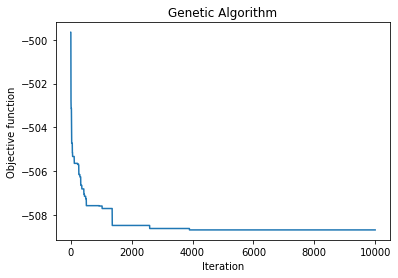

In [ ]:
model.run()

 The best solution found:
 [1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0.
 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0.
 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1.
 0. 1. 1. 1.]

 Objective function:
 -505.93200485229494


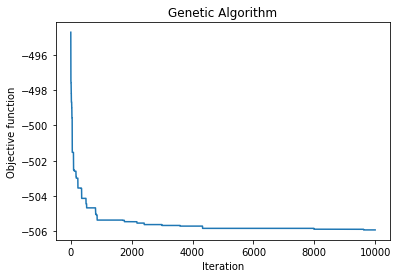

In [ ]:
model5.run()

In [ ]:
model5.output_dict

{'function': -505.93200485229494,
 'variable': array([1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0.,
        1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1.,
        1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1.,
        0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0.,
        0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0.,
        0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1.])}

In [ ]:
ans3 = np.array([1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0.,
        1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1.,
        1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1.,
        0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0.,
        0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0.,
        0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1.]).reshape((10,10))

In [ ]:
convergence=model.report
#solution=model.ouput_dict

In [ ]:
model.report

In [ ]:
ans=[1,1,0, 1, 1,1,0,1,1, 1, 1,0,1,0,1,0,1,0,0,1,1,0,0,1,
0,0,0,1,0,1,1,0,1,0,0,1,0,0,0,1,1,0,0,1,0,0,0,1,
0,1,1,0,0, 1,0, 1,0,0,0,1,1,0,0,1,0,1,0,1,0,1,1,0,
1,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,1,0,1,1,1,1,1,1,
0,1,1,1,]

In [ ]:
ans = np.array(ans).reshape((10,10))

In [ ]:
k=0
turbine_loc = test_loc.copy()
for i in range(10):
  for j in range(10):
    if ans3[i][j]==1 :
      turbine_loc.iat[k,0] = i*400 + 200
      turbine_loc.iat[k,1] = j*400 + 200
      k=k+1
  
turb_coords=turbine_loc.to_numpy()

In [ ]:
turbine_loc.to_csv('sub8.csv',index=False)

In [ ]:
algorithm_param = {'max_num_iteration': 1000,\
                   'population_size':500,\
                   'mutation_probability':0.1,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.5,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':300}

In [ ]:
model2 = ga(function=f,dimension=100, variable_type='bool',algorithm_parameters=algorithm_param)

In [ ]:
model6 = ga(function=f,dimension=100, variable_type='bool',algorithm_parameters=algorithm_param)

In [ ]:
wind.mean()

drct    199.194345
sped      8.882134
dtype: float64

 The best solution found:
 [1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0.
 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0.
 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 1.]

 Objective function:
 -508.86328857421876


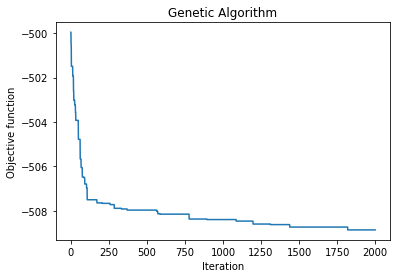

In [ ]:
model2.run()

In [ ]:
ans2 = [1, 1,0,1,1,1,0,1,1,1,1,0,1,0,0,1,0,1,0,1,1,0,0,0,
1,0, 0, 0,0,1,1,0,1,0,0,0,1,0,1,1,1,0,0,0,1,0,0,1,
0,1, 1, 0,1,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,1,1,1,0,
1,0, 0, 1,0,1,0,1,1,0,0,0,1,0,0,0,0,1,1,1,1,1,0,1,
1,1, 1, 1,]

In [ ]:
ans2 = np.array(ans2).reshape((10,10))
k=0

for i in range(10):
  for j in range(10):
    if ans2[i][j]==1 :
      turbine_loc.iat[k,0] = i*400 + 200
      turbine_loc.iat[k,1] = j*400 + 200
      k=k+1
  
turbine_loc.to_csv('sub6.csv',index=False)

In [ ]:
model4 = ga(function=f,dimension=100, variable_type='bool',algorithm_parameters=algorithm_param)

 The best solution found:
 [1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1.
 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0.
 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0.
 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0.
 1. 0. 1. 1.]

 Objective function:
 0


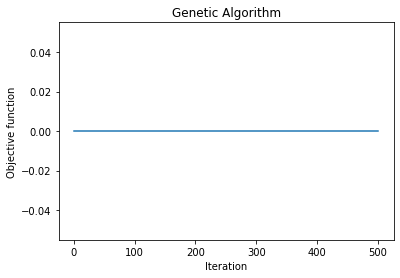

In [ ]:
model4.run()

In [ ]:
def f2(X):
  x,y = np.split(X,2)
  pen=0
  for i in range(50):
    for j in range(i+1,50):
      if (x[i]-x[j])**2 + (y[i]-y[j])**2 <400 :
        pen = pen + 10  
    turbine_loc.iat[i,0] = x[i]
    turbine_loc.iat[i,1] = y[j]
  return pen
  turb_coords=turbine_loc.to_numpy()
  AEP = getAEP(turb_rad, turb_coords, power_curve, wind_inst_freq, 
                  n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t) 
  return -AEP

In [ ]:
algorithm_param = {'max_num_iteration': 5000,\
                   'population_size':200,\
                   'mutation_probability':0.1,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.5,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':2000}

In [ ]:
varbound=np.array([[50,3950]]*100)
model3=ga(function=f2,dimension=100,variable_type='real',variable_boundaries=varbound,algorithm_parameters=algorithm_param)

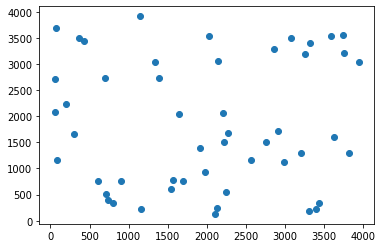

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(x,y)

In [ ]:
pen

25000

In [ ]:
for i in range(50):
  turbine_loc.iat[i,0] = x[i]
  turbine_loc.iat[i,1] = y[j]

In [ ]:
getAEP(turb_rad, turb_coords, power_curve, wind_inst_freq, 
                  n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t) 

372.58497802734377

In [ ]:
turbine_loc.to_csv('sub7.csv',index=False)